# Women's World Cup


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.core.display import display, HTML

import plots as ps

sns.set()
sns.set_palette("GnBu_d", 6)
%matplotlib inline

def create_link(id):
    display(HTML(f'<a id={id}></a>'))


## Analysing Data

In [5]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

display(scores_raw.shape)
display(ranking.shape)

(354, 7)

(150, 3)

In [6]:
scores_raw.head(3)

,Team_i,Team_j,home_i,home_j,score_i,score_j,year
0,china,thailand,0,0,4,0,2018
1,jordan,philippines,1,0,1,2,2018
2,philippines,china,0,0,0,3,2018


In [7]:
ranking.head(3)

,rank,team,rating
0,1,United States,2101
1,2,Germany,2072
2,3,England,2049


In [8]:
scores = scores_raw.drop(columns=['home_i', 'home_j'])
display(scores.info())
display(scores.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
Team_i     354 non-null object
Team_j     354 non-null object
score_i    354 non-null int64
score_j    354 non-null int64
year       354 non-null int64
dtypes: int64(3), object(2)
memory usage: 13.9+ KB


None

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,philippines,china,0,3,2018
3,thailand,jordan,6,1,2018
4,jordan,china,1,8,2018


In [9]:
ranking.team = ranking.team.apply(lambda x: x.lower())
ranking.head(3)

,rank,team,rating
0,1,united states,2101
1,2,germany,2072
2,3,england,2049


### Guarantee that team I and team J respect lexical order

In [10]:
scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_i', 'score_i', 'Team_j', 'score_j']] = \
    scores.loc[scores['Team_j'] < scores['Team_i'], ['Team_j', 'score_j', 'Team_i', 'score_i']].values
        

scores.head()

,Team_i,Team_j,score_i,score_j,year
0,china,thailand,4,0,2018
1,jordan,philippines,1,2,2018
2,china,philippines,3,0,2018
3,jordan,thailand,1,6,2018
4,china,jordan,8,1,2018


### Merging DataFrames

In [11]:
all_matches_i_j = (scores.merge(ranking, left_on='Team_i', right_on='team')
                         .rename(columns={'Team_i': 'team_i',
                                          'rating': 'rating_i',
                                          'rank': 'rank_i'})
                         .drop(columns=['team'])
                         .merge(ranking, left_on='Team_j', right_on='team')
                         .rename(columns={'Team_j': 'team_j',
                                          'rating': 'rating_j',
                                          'rank': 'rank_j'})
                         .drop(columns=['team']))


all_matches = all_matches_i_j.rename(columns={'team_i': 'team_a',
                                              'score_i': 'score_a',
                                              'rank_i': 'rank_a',
                                              'rating_i': 'rating_a',
                                              'team_j': 'team_b',
                                              'score_j': 'score_b',
                                              'rank_j': 'rank_b',
                                              'rating_j': 'rating_b',})

all_matches.head()

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,4,0,2018,16,1866,34,1658
1,china,thailand,3,1,2018,16,1866,34,1658
2,jordan,thailand,1,6,2018,54,1440,34,1658
3,philippines,thailand,1,3,2018,74,1347,34,1658
4,australia,thailand,2,2,2018,6,2003,34,1658


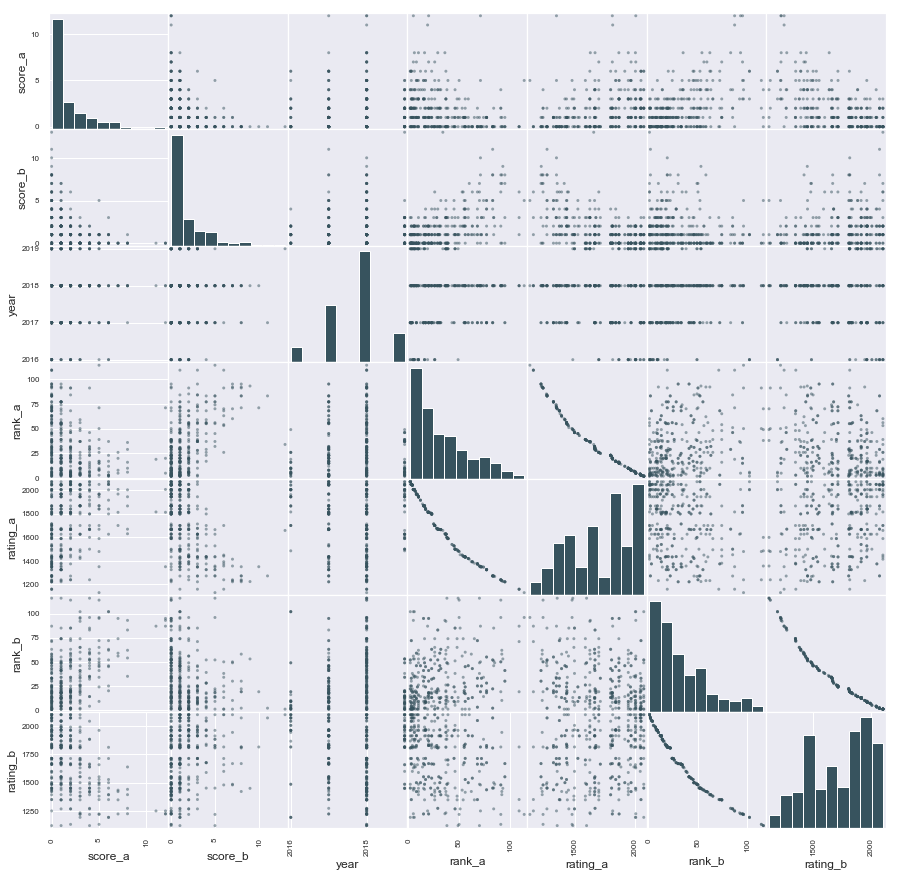

In [12]:
pd.plotting.scatter_matrix(all_matches, figsize=(15,15));

Some points:

countries with more rating play more games. as we can see in `rating_i X rating_i` *(equal to rank_i, rating_j and rank_j)*

There are more games at 2018.

There are some correlations between scores of A and rating that 

In [13]:
all_matches.sample(2, random_state=23)

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
334,czech republic,iceland,1,1,2017,29,1669,22,1806
286,norway,slovakia,6,1,2017,12,1915,46,1499


# Model - Preprocess

For this first model we want to predict which team wons the match.

So, for that we are going to create a column target which says which one wins.

In [14]:
all_matches['target'] = 'draw'
all_matches.loc[all_matches.score_a > all_matches.score_b, ['target']] = 'win_a'
all_matches.loc[all_matches.score_a < all_matches.score_b, ['target']] = 'win_b'
print(f"amount of target values: {all_matches['target'].nunique()}")

amount of target values: 3


In [15]:
for c in all_matches.columns:
    print(f'{c} = {all_matches[c].unique()} \n')

team_a = ['china' 'jordan' 'philippines' 'australia' 'chile' 'sweden' 'argentina'
 'brazil' 'england' 'nigeria' 'equatorial guinea' 'mali' 'germany'
 'south africa' 'russia' 'netherlands' 'denmark' 'croatia' 'hungary'
 'italy' 'canada' 'czech republic' 'faroe islands' 'france' 'scotland'
 'portugal' 'austria' 'israel' 'finland' 'serbia' 'japan' 'new zealand'
 'norway' 'south korea' 'panama' 'mexico' 'trinidad' 'jamaica' 'colombia'
 'thailand' 'albania' 'belarus' 'poland' 'cameroon' 'bolivia'
 'new caledonia' 'cook islands' 'fiji' 'belgium' 'costa rica' 'cuba'
 'algeria' 'ghana' 'ireland' 'northern ireland' 'paraguay' 'peru'
 'ecuador' 'bosnia and herzegovina' 'papua new guinea' 'samoa'
 'kazakhstan' 'moldova' 'iceland'] 

team_b = ['thailand' 'philippines' 'jordan' 'japan' 'south africa' 'sweden'
 'germany' 'spain' 'south korea' 'vietnam' 'united states' 'scotland'
 'canada' 'zimbabwe' 'brazil' 'new zealand' 'italy' 'jamaica' 'ghana'
 'cameroon' 'mali' 'nigeria' 'netherlands' 'zambia' 

We defined ratings as continuous variable and all others are going to be categorical.

In [16]:
X_raw = all_matches.drop(columns=['target', 'score_a', 'score_b'])
y_raw = all_matches['target']

display(X_raw.shape)
display(X_raw.sample(3, random_state=13))

display(y_raw.shape)
display(y_raw.sample(3, random_state=13))

(354, 7)

,team_a,team_b,year,rank_a,rating_a,rank_b,rating_b
259,italy,portugal,2017,15,1868,30,1668
245,kazakhstan,russia,2018,72,1349,25,1713
99,france,united states,2016,4,2043,1,2101


(354,)

259    win_a
245    win_b
99     win_b
Name: target, dtype: object

### Features

In [17]:
# enconding categorical features with one hot encoder
feat_cats = (pd.get_dummies(X_raw[['team_a',
                                   'team_b', 'year']].astype(str)))
print('shape categorycal:')
display(feat_cats.shape)

# normalization numerical features
from sklearn import preprocessing

feat_nums_raw = preprocessing.scale(X_raw[['rating_a', 'rating_b']])
feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])
print('describe numerical:')
display(feat_nums.describe())

# merging data
X = feat_nums.join(feat_cats)
print('shape all merged:')
display(X.shape)

shape categorycal:


(354, 134)

describe numerical:


,rating_a,rating_b
count,3.540000e+02,3.540000e+02
mean,-4.014366e-17,3.211493e-16
std,1.001415e+00,1.001415e+00
min,-2.198113e+00,-2.267244e+00
25%,-8.723496e-01,-8.726298e-01
50%,1.655783e-02,1.752364e-01
75%,9.624465e-01,7.658519e-01
max,1.380309e+00,1.474590e+00


shape all merged:


(354, 136)

##### About Cross Validation

We have to realize that we have few data points, because of that we are NOT follow the default data split:
`Train | Cross Validation | Test`

We are going to use kfold trying to not throw data away. We will define 5 buckets and then we are going to train each algorithm proposed 5 times, using k-1 bucket, and evaluate metric with the one that remains. In conclusion, we will have 5 metrics for each model, the final metric for each model is the average of those metrics. After that, we are going to compare each model to choose the best one.

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

num_folds = 5
kf = KFold(n_splits=num_folds, random_state=43, shuffle=True)
k_fold_indexes = [(train, test) for train, test in kf.split(X)]

labels=['win_a', 'draw', 'win_b']

def train_model_k_fold(model, score):
    scores = []
    confusion_matrixes = []
    
    for train, test in k_fold_indexes:
        X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y_raw.loc[train], y_raw.loc[test]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append(score(y_test, pred))
        confusion_matrixes.append(confusion_matrix(y_test, pred, labels=labels))
    return np.mean(scores)

## The Model - First Scene - Compare some algorithms

Decision Tree: 0.5905030181086519
Logistic Regression: 0.7204024144869215
SVC kernel=linear: 0.6837022132796781
SVC kernel=poly: 0.43211267605633796
SVC kernel=rbf: 0.717625754527163
SVC kernel=sigmoid: 0.720523138832998
Random Forest: 0.652635814889336
Gradient Boosting: 0.666841046277666


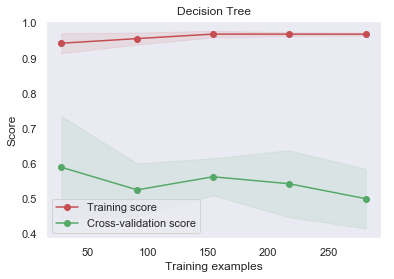

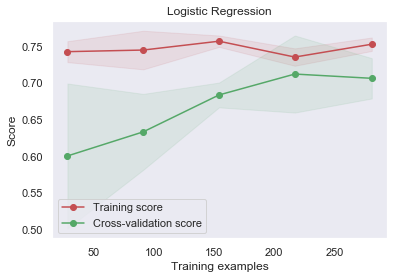

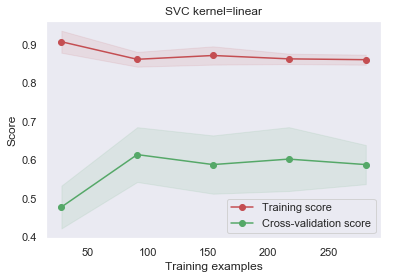

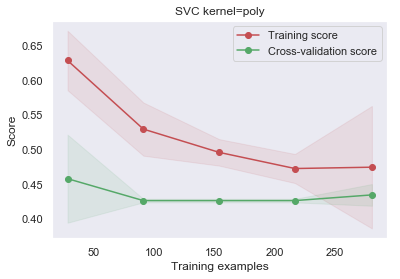

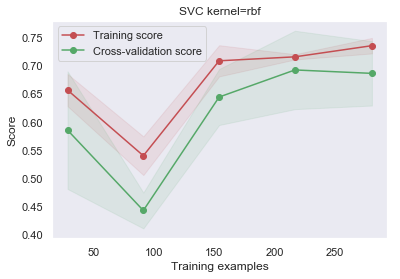

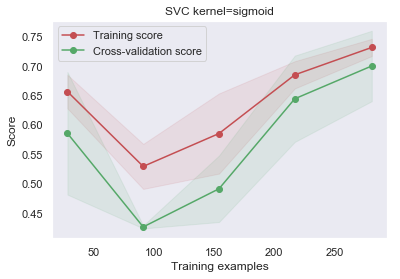

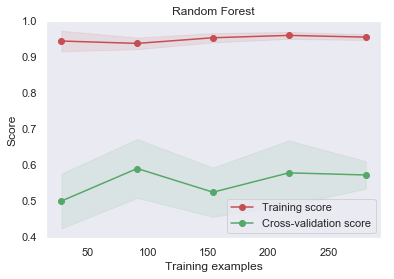

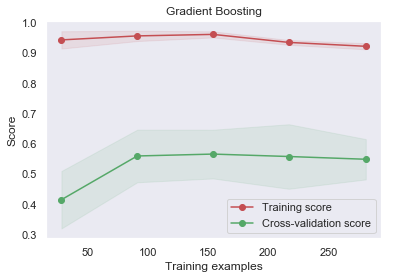

In [32]:
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []

models.append(("Decision Tree", DecisionTreeClassifier(random_state=4)))
models.append(("Logistic Regression", LogisticRegression(solver='lbfgs', C=0.1, multi_class='auto', random_state=4)))
models.append(("SVC kernel=linear", SVC(kernel='linear', random_state=4)))
models.append(("SVC kernel=poly", SVC(kernel='poly', gamma='auto', random_state=4)))
models.append(("SVC kernel=rbf", SVC(kernel='rbf', gamma='auto', random_state=4)))
models.append(("SVC kernel=sigmoid", SVC(kernel='sigmoid', gamma='auto', random_state=4)))
models.append(("Random Forest", RandomForestClassifier(n_estimators=10, random_state=4)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=4)))


for name, model in models:
    print(f'{name}: {train_model_k_fold(model, accuracy_score)}')
    ps.plot_learning_curve(model, name, X, y_raw, cv=5)


#### Feature importance based on decision tree model

In [21]:
feature_importance = zip(X.columns, dt_model.feature_importances_)

for f, importance in sorted(feature_importance, key=lambda x: x[1], reverse=True):
    if importance > 0:
        print(f, importance)

NameError: name 'dt_model' is not defined

In [ ]:
pred = dt_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
accuracy_score(y_test, pred)

In [ ]:
precision_score(y_test, pred, average=None, labels=labels)

In [ ]:
recall_score(y_test, pred, average=None, labels=labels)

In [ ]:
from sklearn.metrics import confusion_matrix
labels=['win_a', 'draw', 'win_b']
cm1=confusion_matrix(y_test, pred, labels=labels)
cm2=confusion_matrix(y_test, pred, labels=labels)

In [ ]:
import plots as ps

from importlib import reload
reload(ps)

ps.print_confusion_matrixes([cm1, cm2, cm2, cm2, cm2], labels)

In [ ]:
ax[i]